# 00 라이브러리 로딩

In [1]:
!pip install sklearn
!pip install matplotlib
!pip install seaborn

In [63]:
import pandas as pd
import numpy as np
import pickle

from gensim.models import word2vec
from sklearn.manifold import TSNE
import matplotlib as mpl
import matplotlib.pyplot as plt
import gensim 
import gensim.models as g

import logging
logging.basicConfig(
    format='%(asctime)s : %(levelname)s : %(message)s', 
    level=logging.INFO)

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
plt.rc('font', family='Malgun Gothic')
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score

In [64]:
def hangul():
    # 한글 폰트 사용을 위해서 세팅
    from matplotlib import font_manager, rc
    font_path = "C:/Windows/Fonts/NGULIM.TTF"
    font = font_manager.FontProperties(fname=font_path).get_name()
    rc('font', family=font)

In [65]:
os.chdir("c:/머신러닝/미니프로젝트/데이터")
print(os.getcwd())

c:\머신러닝\미니프로젝트\데이터


In [66]:
# Load variables #
# 전처리 완료된 학습/테스트 데이터 바로 불러오기 #
with open('sample.pickle', 'rb') as pic:
    train_df, test_df = pickle.load(pic)

In [67]:
from sklearn.model_selection import train_test_split

# shuffle = False

train_df, test_df = train_test_split(train_df, 

                                                    test_size=0.4, 

                                                    shuffle=False, 

                                                    random_state=1004)

In [25]:
test_df = test_df[['글번호','제목','작성일','내용','부서의견','contents','tokens','all_tokens']]

# 민원 건당 단어 수 #
## Word2vec 모델 파라메터 값 설정에 참고될 통계량 ##

### 학습 데이터 ###

In [68]:
train_df['tokens'].str.len().describe()

count    5923.000000
mean       96.220159
std        93.173400
min         0.000000
25%        45.000000
50%        72.000000
75%       116.000000
max      1810.000000
Name: tokens, dtype: float64

### 테스트 데이터 ###

In [69]:
test_df['tokens'].str.len().describe()

count    3949.000000
mean      114.191188
std       118.690910
min         0.000000
25%        51.000000
50%        86.000000
75%       142.000000
max      3364.000000
Name: tokens, dtype: float64

# 01 Word2vec 모델링 #
## 코드 참고 : https://programmers.co.kr/learn/courses/21

## Word2vec 파라미터 값 지정 ##

In [70]:
train = pd.read_csv('train.csv',sep='\t')
train.head(2)

,글번호,제목,작성일,분류,내용,부서의견
0,150587,횡단보도 사각지대 반사경,2012-10-30,교통,운전을 하다보면 횡단보도 주변에 적치물들 때문에 사각지대가 형성되어 사람이 보이지 ...,"좋은 제안 주신 whatsmatter 님께 감사드리며, 제안을 검토한 결과를 다음과..."
1,150594,자전거 횡단보도 내려서 끌고가기,2012-10-30,교통,자전거 횡단보도와 자전거 표지를 보면 마치 자전거를 타고 건너도 되는 것처럼 보이고...,- 말씀하신 제안에는 충분히 공감합니다. 다만 교통안전표지(노면표시)는 도로교통법상...


In [71]:
from sklearn.model_selection import train_test_split


# shuffle = False

train, test = train_test_split(train, 

                                                    test_size=0.4, 

                                                    shuffle=False, 

                                                    random_state=1004)



In [31]:
test = test[['글번호','제목','작성일','내용','부서의견']]
test.head()

,글번호,제목,작성일,내용,부서의견
6406,167828,큰교차로나 일반차도에 미리알수있는 바닥표시판,2014-10-21,안녕하세요 시정관계자님.....우리가 일상생활에서 많이차지하는게 자동차운전입니다길을...,NaN
6407,167829,버스정거장에 열풍기가있으면좋겠어요,2014-10-21,벌써 10월후반입니다요즘들어 날씨가 갈수록 쌀쌀해지고있읍니다앞으로 추운겨울이 점점다...,NaN
6408,167831,서울시 환풍기 시설물 관리 개선 대책,2014-10-21,● 제안취지 현재 법적으로 환풍기 설치에 대하여 국토교통부령으로 정한 ‘건축물의 ...,NaN
6409,167834,삼청동 일대 쓰레기통 설치,2014-10-22,"최근에, 북촌한옥마을 부터 가회동, 삼청동 일대를 방문하게 되었습니다.볼거리가 많아...",NaN
6410,167837,여자 화장실에 어린이용 남자변기 설치,2014-10-22,우리나라의 화장실은 어디를 가든 남자용은 한가한데 여자화장실은 항상 줄이 서있습니...,NaN


In [72]:
train_documents = train_df['tokens'].to_list() # 학습데이터 토크나이징 완료한 문서
test_documents = test_df['tokens'].to_list() # 학습데이터 토크나이징 완료한 문서

In [73]:
num_features = 500 # 문자 벡터 차원 수
min_word_count = 40 # 최소 문자 수 (등장빈도 40회 이하인 단어는 취급 X)
num_workers = 6 # 병렬 처리 스레드 수
context = 20 # 문자열 창 크기
downsampling = 1e-3 # 문자 빈도수 Downsample

## 모델 학습 ##

In [74]:
# 문장을 이용하여 단어와 벡터를 생성한다.
model = word2vec.Word2Vec(train_documents,
                          workers=num_workers, 
                          vector_size=num_features, 
                          min_count=min_word_count,
                          window=context,
                          sample=downsampling)

2022-03-12 13:02:50,690 : INFO : collecting all words and their counts
2022-03-12 13:02:50,691 : INFO : PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
2022-03-12 13:02:50,783 : INFO : collected 23133 word types from a corpus of 569912 raw words and 5923 sentences
2022-03-12 13:02:50,784 : INFO : Creating a fresh vocabulary
2022-03-12 13:02:50,802 : INFO : Word2Vec lifecycle event {'msg': 'effective_min_count=40 retains 2553 unique words (11.03618207755155%% of original 23133, drops 20580)', 'datetime': '2022-03-12T13:02:50.802823', 'gensim': '4.1.2', 'python': '3.9.7 (default, Sep 16 2021, 16:59:28) [MSC v.1916 64 bit (AMD64)]', 'platform': 'Windows-10-10.0.22000-SP0', 'event': 'prepare_vocab'}
2022-03-12 13:02:50,802 : INFO : Word2Vec lifecycle event {'msg': 'effective_min_count=40 leaves 446165 word corpus (78.28664776316343%% of original 569912, drops 123747)', 'datetime': '2022-03-12T13:02:50.802823', 'gensim': '4.1.2', 'python': '3.9.7 (default, Sep 16 2021, 16:

In [75]:
# 모델 확인
model

### 특정 단어와 가장 유사한 단어 추출 ###

In [76]:
model.wv.most_similar('자전거')

[('도난', 0.7836079001426697),
 ('공공자전거', 0.7713324427604675),
 ('대여소', 0.7307595610618591),
 ('자전거도로', 0.6922687888145447),
 ('보관소', 0.6748361587524414),
 ('대여', 0.6687586307525635),
 ('빌리다', 0.640824019908905),
 ('전동휠체어', 0.6327247619628906),
 ('수리', 0.6280931234359741),
 ('수상', 0.6049340963363647)]

In [77]:
model.wv.most_similar('도서관')

[('도서', 0.9328919649124146),
 ('책', 0.9130744934082031),
 ('공공도서관', 0.8650210499763489),
 ('시립', 0.7747664451599121),
 ('교환', 0.7277569770812988),
 ('반납', 0.6907364726066589),
 ('구립', 0.6900768280029297),
 ('독서', 0.6752644181251526),
 ('대출', 0.6726968884468079),
 ('고도', 0.6251904368400574)]

In [78]:
model.wv.most_similar('담배')

[('흡연자', 0.9489367008209229),
 ('흡연', 0.9226299524307251),
 ('흡연구역', 0.9217460751533508),
 ('피우다', 0.9172914624214172),
 ('술', 0.8565719723701477),
 ('간접흡연', 0.8536083698272705),
 ('흡연실', 0.8350812792778015),
 ('꽁초', 0.8264760971069336),
 ('담배꽁초', 0.8110034465789795),
 ('금연', 0.8059322237968445)]

### 입력한 복수의 단어 中 유사하지 않은 단어 추출 ###

In [79]:
model.wv.doesnt_match('자전거 버스 택시'.split())

'자전거'

In [80]:
model.wv.doesnt_match('임산부 노인 시민'.split())

'시민'

### 학습 완료 후 필요없는 메모리 unload ###

In [81]:
model.init_sims(replace=True)

C:\Users\dkq50\AppData\Local\Temp/ipykernel_22320/1992334471.py:1: DeprecationWarning: Call to deprecated `init_sims` (Gensim 4.0.0 implemented internal optimizations that make calls to init_sims() unnecessary. init_sims() is now obsoleted and will be completely removed in future versions. See https://github.com/RaRe-Technologies/gensim/wiki/Migrating-from-Gensim-3.x-to-4).
  model.init_sims(replace=True)
2022-03-12 13:03:00,566 : WARNING : destructive init_sims(replace=True) deprecated & no longer required for space-efficiency


### 모델 저장 ###

In [82]:
model_name = '500features_40minwords_20context' #모델 이름 지정
model.save(f'./{model_name}')

2022-03-12 13:03:01,908 : INFO : Word2Vec lifecycle event {'fname_or_handle': './500features_40minwords_20context', 'separately': 'None', 'sep_limit': 10485760, 'ignore': frozenset(), 'datetime': '2022-03-12T13:03:01.908291', 'gensim': '4.1.2', 'python': '3.9.7 (default, Sep 16 2021, 16:59:28) [MSC v.1916 64 bit (AMD64)]', 'platform': 'Windows-10-10.0.22000-SP0', 'event': 'saving'}
2022-03-12 13:03:01,909 : INFO : not storing attribute cum_table
2022-03-12 13:03:01,919 : INFO : saved ./500features_40minwords_20context


### 모델 로드

In [83]:
# 추후 필요할 때 활용
model = word2vec.Word2Vec.load('./500features_40minwords_20context')

2022-03-12 13:03:05,287 : INFO : loading Word2Vec object from ./500features_40minwords_20context
2022-03-12 13:03:05,292 : INFO : loading wv recursively from ./500features_40minwords_20context.wv.* with mmap=None
2022-03-12 13:03:05,293 : INFO : setting ignored attribute cum_table to None
2022-03-12 13:03:05,319 : INFO : Word2Vec lifecycle event {'fname': './500features_40minwords_20context', 'datetime': '2022-03-12T13:03:05.319483', 'gensim': '4.1.2', 'python': '3.9.7 (default, Sep 16 2021, 16:59:28) [MSC v.1916 64 bit (AMD64)]', 'platform': 'Windows-10-10.0.22000-SP0', 'event': 'loaded'}


### Word2Vec 모델

In [84]:
from gensim.models import Word2Vec

# 단어벡터를 구한다.
word_vectors = model.wv

vocabs= word_vectors.key_to_index.keys()
word_vectors_list = [word_vectors[v] for v in vocabs]

### 임베딩 결과 시각화
#### 1) PCA
300차원 벡터를 시각화하기 위해서는 2차원 혹은 3차원으로 벡터를 축소하는 과정이 필요합니다. 이런 방식을 '차원 축소'라고 부르고, PCA는 대표적인 차원 축소 방식 중 하나 입니다. 

In [85]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
xys = pca.fit_transform(word_vectors_list[:100])
xs = xys[:,0]
ys = xys[:,1]

사이킷런의 PCA 모듈을 이용했다. n_components는 input 데이터를 몇 차원으로 축소시킬 것인지를 의미합니다. 2차원 벡터의 x 값은 xs에, y 값은 ys에 저장했습니다.

In [86]:
# 단어와 2차원 X축의 값, Y축의 값을 입력받아 2차원 그래프를 그린다
def plot_2d_graph(vocabs, xs, ys):
    plt.figure(figsize=(15 ,10))
    plt.scatter(xs, ys, marker = 'o')
    for i, v in enumerate(list(vocabs)[:100]):
        plt.annotate(v, xy=(xs[i], ys[i]))

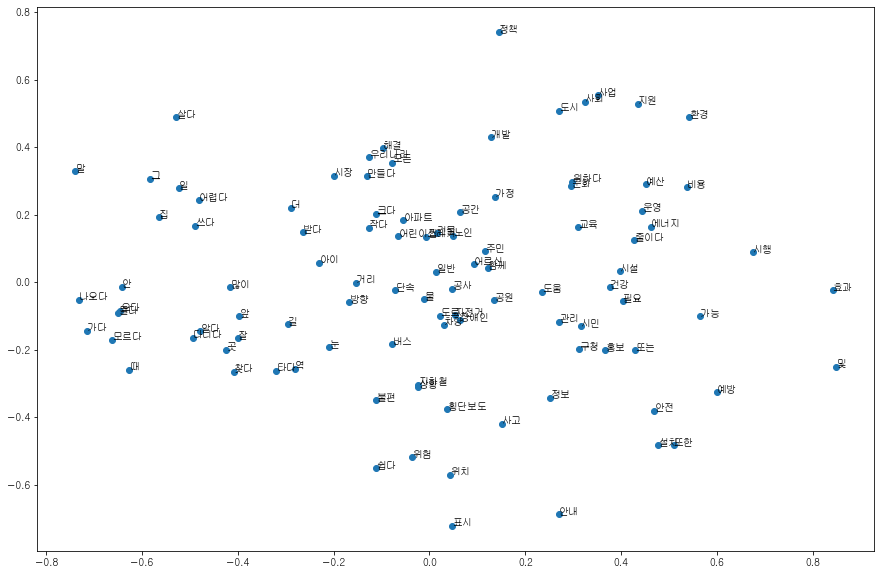

In [87]:
hangul()
plot_2d_graph(vocabs, xs, ys)

많은 벡터가 가운데에 모여 있는 것을 확인할 수 있습니다. 300차원의 벡터를 2차원에 나타내다 보니 결과가 아주 우수하다고 보기는 어려움

#### 2) t-SNE
PCA가 자주 이용되는 차원 축소 방식이긴 하지만, 위의 결과와 같이 PCA는 군집의 변별력을 죽인다는 단점이 있습니다. (자세한 내용은 여기서 확인할 수 있다.) 이러한 단점을 개선한 방식이 t-SNE 차원축소 방식입니다. 실제로 임베딩 결과는 t-SNE로 나타내는 경우가 많습니다.

C:\Users\dkq50\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(


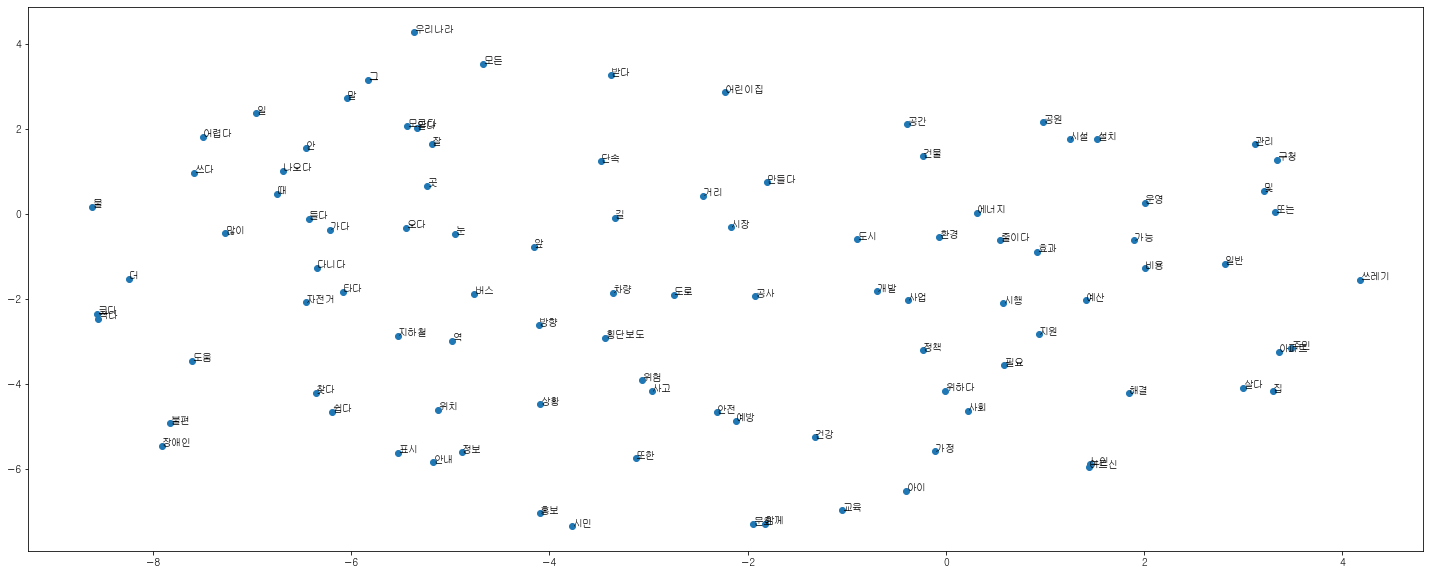

In [247]:
from sklearn.manifold import TSNE

model2 = TSNE(learning_rate=100)
transformed = model2.fit_transform(word_vectors_list[:100])

xs2 = transformed[:,0]
ys2 = transformed[:,1]

plt.figure(figsize=(25,10))

plt.scatter(xs2, ys2)
for i,v in enumerate(list(vocabs)[:100]):
    plt.annotate(v, xy=(xs2[i], ys2[i]))

plt.show()

In [115]:
from sklearn.manifold import TSNE

# 2차원 t-SNE 임베딩
model2 = TSNE(n_components=2)
transformed2 = model2.fit_transform(word_vectors_list[:100])

# 3차원 t-SNE 임베딩
model3 = TSNE(n_components=3)
transformed3 = model3.fit_transform(word_vectors_list)

# numpy array -> DataFrame 변환
tsne_df2 = pd.DataFrame(transformed2, columns = ['component 0', 'component 1'])
tsne_df3 = pd.DataFrame(transformed3, columns = ['component 0', 'component 1','component 2'])

C:\Users\dkq50\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
C:\Users\dkq50\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
C:\Users\dkq50\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
C:\Users\dkq50\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


In [116]:
set(train['분류'])

{'건강', '경제', '교통', '문화', '복지', '세금', '안전', '여성', '주택', '환경'}

2차원

<민원 분류 개수> 
 교통    18
안전    15
건강    15
환경    13
문화    11
복지    10
주택     8
경제     6
여성     4
Name: target, dtype: int64


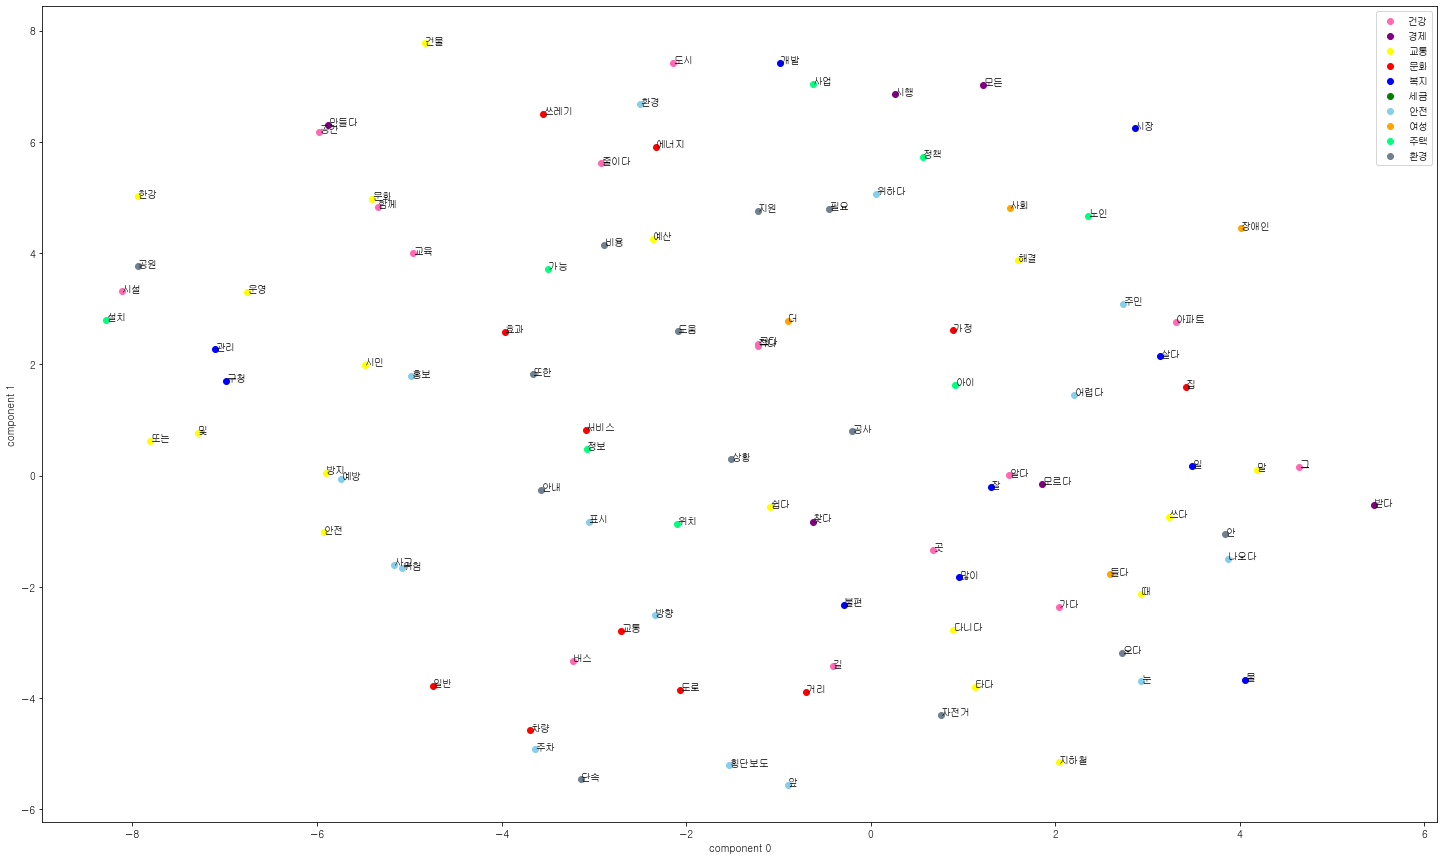

In [117]:
import matplotlib.pyplot as plt

tsne_df = tsne_df2
# class target 정보 불러오기 
tsne_df['target'] = train['분류']

# target 별 분리
tsne_df_0 = tsne_df[tsne_df['target'] == '건강']
tsne_df_1 = tsne_df[tsne_df['target'] == '경제']
tsne_df_2 = tsne_df[tsne_df['target'] == '교통']
tsne_df_3 = tsne_df[tsne_df['target'] == '문화']
tsne_df_4 = tsne_df[tsne_df['target'] == '복지']
tsne_df_5 = tsne_df[tsne_df['target'] == '세금']
tsne_df_6 = tsne_df[tsne_df['target'] == '안전']
tsne_df_7 = tsne_df[tsne_df['target'] == '여성']
tsne_df_8 = tsne_df[tsne_df['target'] == '주택']
tsne_df_9 = tsne_df[tsne_df['target'] == '환경']


plt.figure(figsize=(25,15))
print('<민원 분류 개수> \n',tsne_df2['target'].value_counts())

# target 별 시각화
plt.scatter(tsne_df_0['component 0'], tsne_df_0['component 1'], color = 'hotpink', label = '건강')
plt.scatter(tsne_df_1['component 0'], tsne_df_1['component 1'], color = 'purple', label = '경제')
plt.scatter(tsne_df_2['component 0'], tsne_df_2['component 1'], color = 'yellow', label = '교통')
plt.scatter(tsne_df_3['component 0'], tsne_df_3['component 1'], color = 'red', label = '문화')
plt.scatter(tsne_df_4['component 0'], tsne_df_4['component 1'], color = 'blue', label = '복지')
plt.scatter(tsne_df_5['component 0'], tsne_df_5['component 1'], color = 'green', label = '세금')
plt.scatter(tsne_df_6['component 0'], tsne_df_6['component 1'], color = 'skyblue', label = '안전')
plt.scatter(tsne_df_7['component 0'], tsne_df_7['component 1'], color = 'orange', label = '여성')
plt.scatter(tsne_df_8['component 0'], tsne_df_8['component 1'], color = 'springgreen', label = '주택')
plt.scatter(tsne_df_9['component 0'], tsne_df_9['component 1'], color = 'slategray', label = '환경')

for i,v in enumerate(list(vocabs)[:100]):
    plt.annotate(v, xy=(tsne_df2['component 0'][i], tsne_df2['component 1'][i]))




plt.xlabel('component 0')
plt.ylabel('component 1')
plt.legend()
plt.show()


3차원

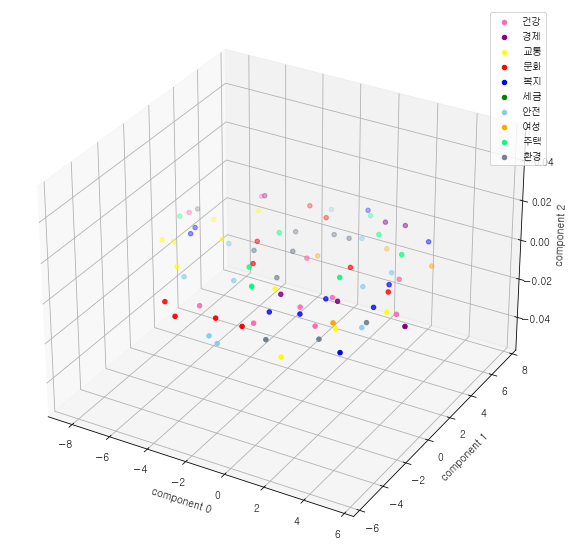

In [118]:
from mpl_toolkits.mplot3d import Axes3D

# 3차원 그래프 세팅
fig = plt.figure(figsize=(15, 10))
ax = fig.add_subplot(111, projection='3d')

# class target 정보 불러오기 
tsne_df['target'] = train['분류']

# target 별 분리
tsne_df_0 = tsne_df[tsne_df['target'] == '건강']
tsne_df_1 = tsne_df[tsne_df['target'] == '경제']
tsne_df_2 = tsne_df[tsne_df['target'] == '교통']
tsne_df_3 = tsne_df[tsne_df['target'] == '문화']
tsne_df_4 = tsne_df[tsne_df['target'] == '복지']
tsne_df_5 = tsne_df[tsne_df['target'] == '세금']
tsne_df_6 = tsne_df[tsne_df['target'] == '안전']
tsne_df_7 = tsne_df[tsne_df['target'] == '여성']
tsne_df_8 = tsne_df[tsne_df['target'] == '주택']
tsne_df_9 = tsne_df[tsne_df['target'] == '환경']

# target 별 시각화
ax.scatter(tsne_df_0['component 0'][:10], tsne_df_0['component 1'][:10], color = 'hotpink', label = '건강')
ax.scatter(tsne_df_1['component 0'][:10], tsne_df_1['component 1'][:10], color = 'purple', label = '경제')
ax.scatter(tsne_df_2['component 0'][:10], tsne_df_2['component 1'][:10], color = 'yellow', label = '교통')
ax.scatter(tsne_df_3['component 0'][:10], tsne_df_3['component 1'][:10], color = 'red', label = '문화')
ax.scatter(tsne_df_4['component 0'][:10], tsne_df_4['component 1'][:10], color = 'blue', label = '복지')
ax.scatter(tsne_df_5['component 0'][:10], tsne_df_5['component 1'][:10], color = 'green', label = '세금')
ax.scatter(tsne_df_6['component 0'][:10], tsne_df_6['component 1'][:10], color = 'skyblue', label = '안전')
ax.scatter(tsne_df_7['component 0'][:10], tsne_df_7['component 1'][:10], color = 'orange', label = '여성')
ax.scatter(tsne_df_8['component 0'][:10], tsne_df_8['component 1'][:10], color = 'springgreen', label = '주택')
ax.scatter(tsne_df_9['component 0'][:10], tsne_df_9['component 1'][:10], color = 'slategray', label = '환경')

ax.set_xlabel('component 0')
ax.set_ylabel('component 1')
ax.set_zlabel('component 2')
ax.legend()
plt.show()


## 문서별 평균 feature 계산 ##

### 주어진 민원 문서에서 단어 벡터의 평균 구하는 함수 ###

In [88]:
def makeFeatureVec(words, model, num_features):
    featureVec = np.zeros((num_features,),dtype="float32")
    nwords = 0.
    index2word_set = set(model.wv.index_to_key)
    for word in words:
        if word in index2word_set:
            nwords = nwords + 1.
            featureVec = np.add(featureVec,word_vectors[word])
    np.seterr(divide='ignore')
    featureVec = np.divide(featureVec,nwords)
    return featureVec

### 단어 평균 feature 벡터를 배열로 반환 ###

In [89]:
def getAvgFeatureVecs(documents, model, num_features):
    counter = 0.
    documentFeatureVecs = np.zeros(
        (len(documents),num_features),dtype="float32")
    for document in documents:
       if counter%2000. == 0.:
           print("민원 %d of %d" % (counter, len(documents)))
       documentFeatureVecs[int(counter)] = makeFeatureVec(document, model, num_features)
       counter = counter + 1.
    return documentFeatureVecs

### 학습 데이터 평균 feature 계산 ###

In [90]:
%time trainDataVecs = getAvgFeatureVecs(\
    train_documents, model, num_features)


민원 0 of 5923


C:\Users\dkq50\AppData\Local\Temp/ipykernel_22320/325302873.py:10: RuntimeWarning: invalid value encountered in true_divide
  featureVec = np.divide(featureVec,nwords)


민원 2000 of 5923
민원 4000 of 5923
Wall time: 1.33 s


In [91]:
imp = SimpleImputer(missing_values=np.nan, strategy='mean')
imp.fit(trainDataVecs)
trainDataVecs=imp.transform(trainDataVecs) ##nan, infinite 제거

## 랜덤 포레스트로 민원 자동분류 ##

### 랜덤 포레스트 분류기 설정 ###
  - n_estimators : 생성할 트리 개수 (k)
  - n_jobs : 학습을 수행하기 위해 CPU 코어 2개를 병렬적으로 활용한다는 의미
  - 같은 결과를 만들어야 한다면 random_state 값을 고정해야함 

In [92]:
forest_w2v = RandomForestClassifier(n_estimators = 300, random_state = 7, class_weight='balanced')

### 랜덤포레스트 모델 = Y: 민원분류, X:민원 문서당 평균 단어 feature ###

In [ ]:
%time forest_w2v_fit = forest_w2v.fit(trainDataVecs, train_df["분류"])

Wall time: 40.8 s


### cross validation 활용해 정확도 평가 ###

In [ ]:
# n개로 분할해 평가
%time score = np.mean(cross_val_score(\
    forest_w2v_fit, trainDataVecs, \
    train_df["분류"], cv=100))

Wall time: 1h 6min 54s


In [ ]:
# 정확도(accuracy)
score

0.7006215213358071

* cv = 10  : 0.696
* cv = 30  : 0.700
* cv = 100 : 0.701

## Logistic Regression(로지스틱 회귀)
* cv = 3 : 0.7037
* cv = 10 : 0.7119

In [211]:
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression

# 모델
logreg = LogisticRegression()

# 파라미터는 (모델, Traingdata의 feature, Trainingdata의 target, 폴드수) 이다.
scores = cross_val_score(logreg , trainDataVecs, train_df["분류"] ,cv=10)

# Trainingdata에 대한 성능을 나타낸다.
print('교차 검증별 정확도:',np.round(scores, 4))
print('평균 검증 정확도:', np.round(np.mean(scores), 4))


C:\Users\dkq50\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\dkq50\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_

교차 검증별 정확도: [0.6746 0.637  0.6529 0.6529 0.641  0.6396 0.6343 0.6077 0.6516 0.6356]
평균 검증 정확도: 0.6427


C:\Users\dkq50\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


* KFold 상세 조정

    * 위 cross_val_score 함수에서는, cv로 폴드의 수를 조정할 수 있었다.

    * 만약 검증함수의 매개변수를 디테일하게 제어하고 싶다면

    * 따로 검증함수 객체를 만들고 매개변수를 조정한 다음, 해당 객체를 cross_val_score의 cv 매개변수에 넣을 수도 있다.

    * 이를 '교차 검증 분할기' 라고도 한다.

* n_splits= 5 : 0.6592
* n_splits= 6 : 0.7125 **
* n_splits= 10 : 0.6623

In [212]:
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score

# 모델
logreg = LogisticRegression()

# n_split : 몇개로 분할할지
# shuffle : Fold를 나누기 전에 무작위로 섞을지
# random_state : 나눈 Fold를 그대로 사용할지
kfold = KFold(n_splits=6, shuffle = True, random_state=0)

# 파라미터는 (모델, Traingdata의 feature, Trainingdata의 target, 폴드수) 이다.
scores = cross_val_score(logreg, trainDataVecs, train_df["분류"],cv=kfold)

# Trainingdata에 대한 성능을 나타낸다.
print('교차 검증별 정확도:',np.round(scores, 4))
print('평균 검증 정확도:', np.round(np.mean(scores), 4))

C:\Users\dkq50\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\dkq50\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_

교차 검증별 정확도: [0.6523 0.6483 0.6332 0.6377 0.6385 0.6544]
평균 검증 정확도: 0.6441


C:\Users\dkq50\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


## KNN으로 분류

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split

In [ ]:
knn = KNeighborsClassifier(n_neighbors=3)
X_train, X_test, Y_train, Y_test = train_test_split(trainDataVecs, train_df['분류'], test_size = 0.25, stratify = train_df['분류'])

In [ ]:
knn.fit(X_train, Y_train)

KNeighborsClassifier(n_neighbors=3)

In [ ]:
Y_pred = knn.predict(X_test)

In [ ]:
print("prediction accuracy: {:.2f}".format(np.mean(Y_pred == Y_test)))

prediction accuracy: 0.64


# SVM

In [ ]:
from sklearn.model_selection import train_test_split, GridSearchCV
X_train, X_test, y_train, y_test = train_test_split(trainDataVecs, train_df['분류'], test_size = 0.3, random_state = 123)


In [ ]:
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaler.fit(X_train)
ttrain = scaler.transform(X_train)

model_SVC = SVC(kernel='rbf', C=5, gamma = 'auto')
model_SVC.fit(X_train, y_train)

from sklearn.metrics import accuracy_score
X_test = scaler.transform(X_test)
y_pred = model.predict(X_test)
accuracy_score(y_test, y_pred)

0.6006909164803902

# Naive Bayes

In [ ]:
from sklearn.naive_bayes import GaussianNB

X_train, X_test, y_train, y_test = train_test_split(trainDataVecs, train_df['분류'], test_size=0.5, random_state= 0)

nb= GaussianNB()

y_pred = nb.fit(X_train, y_train).predict(X_test)

print("정확도 : ", accuracy_score(y_test, y_pred))

정확도 :  0.5718349928876245


### 최종 모델을 활용해서 테스트 데이터 민원 자동 분류 ###

In [94]:
# 테스트 데이터 벡터화
%time testDataVecs = getAvgFeatureVecs(\
        test_documents, model, num_features )
imp.fit(testDataVecs)
testDataVecs=imp.transform(testDataVecs) ##nan, infinite 제거

민원 0 of 3949


C:\Users\dkq50\AppData\Local\Temp/ipykernel_22320/325302873.py:10: RuntimeWarning: invalid value encountered in true_divide
  featureVec = np.divide(featureVec,nwords)


민원 2000 of 3949
Wall time: 995 ms


In [95]:
# 문서별 민원 분류 확률값 저장
forest_w2v_proba = forest_w2v.predict_proba(testDataVecs)

In [96]:
# 민원 분류 확률 Top2
topn = 2
topn_class = np.argsort(forest_w2v_proba)[:,:-topn-1:-1]
forest_w2v.classes_[topn_class]

result_w2v_top1 = forest_w2v.classes_[topn_class][:,0]
result_w2v_top2 = forest_w2v.classes_[topn_class][:,1]

In [98]:
# 민원 분류 결과 데이터프레임으로 저장
output_w2v = pd.DataFrame(data={'글번호':test_df['글번호'], '분류':result_w2v_top1,'분류2':result_w2v_top2})
output_w2v

,글번호,분류,분류2
6614,168288,교통,안전
6615,168290,환경,안전
6616,168292,환경,교통
6617,168293,교통,문화
6618,168295,안전,교통
...,...,...,...
10672,179106,교통,복지
10673,179107,주택,문화
10674,179108,안전,교통
10675,179109,환경,문화


In [99]:
# 민원 예측 결과 통계량
print(output_w2v['분류'].value_counts())

환경    1189
교통     941
문화     441
안전     362
건강     269
복지     254
주택     197
경제     140
여성     123
세금      33
Name: 분류, dtype: int64


In [100]:
# 민원 분류 예측 결과를 test_df에 merge
result_df=pd.merge(test_df,output_w2v,on='글번호')
result_df

,글번호,제목,작성일,분류_x,내용,부서의견,contents,tokens,all_tokens,분류_y,분류2
0,168288,신호등 관련,2014-11-21,교통,안녕하세요. 외국을 다니다 보니 다른나라는 자동차 신호등에도 타이머가 있습니다. 서...,NaN,신호등 관련\n안녕하세요. 외국을 다니다 보니 다른나라는 자동차 신호등에도 타이머가...,"[신호등, 외국, 다니다, 나라, 자동차, 신호등, 타이머, 보행자, 신호, 타이머...","[신호등, 외국, 다니, 보, 니, 나라, 는, 자동차, 신호등, 에, 도, 타이머...",교통,안전
1,168290,도로주변의 유적지 보호,2014-11-21,문화,아침뉴스에 자동차 한대가 사직단 대문을 받았다는 소식이 있었습니다.400년 넘은 문...,choiss0님 안녕하십니까? 우리 문화재에 대해 깊은 관심과 애정을 가지고 의견 ...,도로주변의 유적지 보호\n아침뉴스에 자동차 한대가 사직단 대문을 받았다는 소식이 있...,"[도로, 유적지, 보호, 아침, 뉴스, 자동차, 한대, 사직단, 대문, 받다, 소식...","[도로, 의, 유적지, 보호, 아침, 뉴스, 에, 자동차, 한대, 가, 사직단, 대...",환경,안전
2,168292,자전거 보호강화 및 거치대 활용방안,2014-11-21,교통,열정을 갖고 시정을 챙겨주셔서 감사하다는 말씀을 먼저 드립니다. 제가 최근에 황당한...,NaN,자전거 보호강화 및 거치대 활용방안\n열정을 갖고 시정을 챙겨주셔서 감사하다는 말씀...,"[자전거, 보호, 강화, 및, 거치다, 열정, 시정, 챙겨주다, 말씀, 먼저, 드리...","[자전거, 보호, 강화, 및, 거치, 대, 열정, 가지, 고, 시정, 챙겨주, 시,...",환경,교통
3,168293,레일바이크,2014-11-21,환경,보통 레일바이크를 타려면 서울보다 멀리 가야 합니다. 하지만 가까운데에 레일 바이크...,NaN,레일바이크\n보통 레일바이크를 타려면 서울보다 멀리 가야 합니다. 하지만 가까운데에...,"[레일, 바이크, 보통, 레일, 바이크, 타다, 멀리, 가다, 가깝다, 레일, 바이...","[레일, 바이크, 보통, 레일, 바이크, 를, 타, 려면, 멀리, 가, 아야, 하,...",교통,문화
4,168295,당곡사거리~숭실대입구역 삼거리를 직선으로 연결하는 가칭 당곡터널의 건설을 제안합니다.,2014-11-21,안전,"택시일을 4년째 하면서 강남권에서 신림동,봉천동 방향의 승객을 모실때 남부순환로길이...",ohc1968님 안녕하세요? 귀하께서는 택시업계에 종사하시면서 승객의 편의 및 시정...,당곡사거리~숭실대입구역 삼거리를 직선으로 연결하는 가칭 당곡터널의 건설을 제안합니다...,"[당, 곡, 사거리, 숭실대, 입, 구역, 삼거리, 직선, 연결, 가칭, 당, 곡,...","[당, 곡, 사거리, 숭실대, 입, 구역, 삼거리, 를, 직선, 으로, 연결, 하,...",안전,교통
...,...,...,...,...,...,...,...,...,...,...,...
3944,179106,지하철 임산부 지정석 관련,2017-08-31,교통,안녕하세요 수고하십니다.다름이 아니오라 지하철 임산부지정석 관련 건의 드립니다.현...,김혁님 안녕하십니까? 제안 참여에 감사드리며 “지하철 임산부 지정석”건에 대하여 답...,지하철 임산부 지정석 관련\n안녕하세요 수고하십니다.다름이 아니오라 지하철 임산부...,"[지하철, 임산부, 지정석, 다르다, 오라, 지하철, 임산부, 지정석, 건의, 드리...","[지하철, 임산부, 지정석, 하, 시, ㅂ니다, 다르, ㅁ, 아니, 오라, 지하철,...",교통,복지
3945,179107,채동선 작곡가의 서울 집을 보존해 주세요.,2017-08-31,문화,서울 성북동의 옛날짜장면집 뒷 골목에 한옥집들 사이로 고풍스러운 2층 적산가옥이 보...,NaN,채동선 작곡가의 서울 집을 보존해 주세요.\n서울 성북동의 옛날짜장면집 뒷 골목에 ...,"[동서, 작곡가, 집, 보존, 성북동, 옛날, 짜장면, 집, 뒤, 골목, 한옥, 집...","[채, 동서, ㄴ, 작곡가, 의, 집, 보존, 하, 아, 주, 시, 어요, 성북동,...",주택,문화
3946,179108,한강및 지천에서의 안전,2017-08-31,환경,시민의 안전과 편의를 위하여 불철주야 수고 하심에 감사드립니다.저는 주로 한강및 한...,NaN,한강및 지천에서의 안전\n시민의 안전과 편의를 위하여 불철주야 수고 하심에 감사드립...,"[한강, 및, 지천, 안전, 시민, 안전, 편의, 위하다, 불철주야, 감사드리다, ...","[한강, 및, 지천, 에서, 의, 안전, 시민, 의, 안전, 과, 편의, 를, 위하...",안전,교통
3947,179109,세빛섬 이전 가능한가 ?,2017-08-31,환경,안녕하세요 ?최근에 노들섬이 2018년 말 경 개발된다는 기사를 본것 같습니다.예전...,NaN,세빛섬 이전 가능한가 ?\n안녕하세요 ?최근에 노들섬이 2018년 말 경 개발된다는...,[],[세빛섬 이전 가능한가 안녕하세요 최근에 노들섬이 2018년 말 경 개발된다는 기사...,환경,문화


### 민원분류 예측결과 엑셀파일로 저장

In [145]:
pip install xlsxwriter

  Using cached XlsxWriter-3.0.3-py3-none-any.whl (149 kB)
Note: you may need to restart the kernel to use updated packages.


In [54]:
result_df.to_excel('민원분류 예측결과.xlsx',index=None)

### 분류 결과 도표 시각화 ###

C:\Users\dkq50\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\Users\dkq50\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Text(0.5, 1.0, '테스트 데이터')

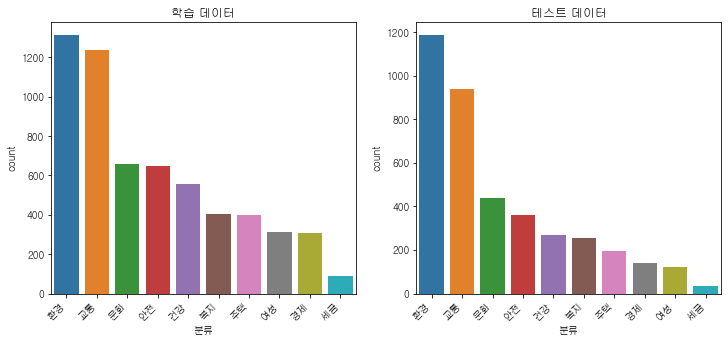

In [102]:
#학습 데이터 민원 분류 비율 vs 테스트 데이터 민원 분류 비율 #
fig, axes = plt.subplots(ncols=2)
fig.set_size_inches(12,5)

#학습 데이터 플롯
train_plot = sns.countplot(train_df['분류'], ax=axes[0],order=train_df['분류'].value_counts().index.to_list())
train_plot.set_xticklabels(train_plot.get_xticklabels(),rotation=45,ha='right')
train_plot.set_title('학습 데이터')

#테스트 데이터 플롯
test_plot = sns.countplot(output_w2v['분류'], ax=axes[1],order=result_df['분류_y'].value_counts().index.to_list())
test_plot.set_xticklabels(test_plot.get_xticklabels(),rotation=45,ha='right')
test_plot.set_title('테스트 데이터')